<a href="https://colab.research.google.com/github/amsc101/ICU/blob/master/ICU_Mortality_v3_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ICU Mortality Prediction

In [0]:
# Import libraries
import numpy as np
import matplotlib
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

#### 1. Data visualitation 

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/training_v2.csv")
data.head()

encounter_id  patient_id  ...  apache_3j_bodysystem  apache_2_bodysystem
0         66154       25312  ...                Sepsis       Cardiovascular
1        114252       59342  ...           Respiratory          Respiratory
2        119783       50777  ...             Metabolic            Metabolic
3         79267       46918  ...        Cardiovascular       Cardiovascular
4         92056       34377  ...                Trauma               Trauma

[5 rows x 186 columns]

In [0]:
y=data['hospital_death']

In [0]:
type(data['hospital_death'][0])

numpy.int64

In [0]:
print('nº of variables : ', data.shape[1],'\nnº of patients: ', data.shape[0])

nº of variables :  186 
nº of patients:  91713


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [0]:
df = data[data.columns[0:20]]
df.isna().sum()

encounter_id                 0
patient_id                   0
hospital_id                  0
hospital_death               0
age                       4228
bmi                       3429
elective_surgery             0
ethnicity                 1395
gender                      25
height                    1334
hospital_admit_source    21409
icu_admit_source           112
icu_id                       0
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
readmission_status           0
weight                    2720
albumin_apache           54379
apache_2_diagnosis        1662
dtype: int64

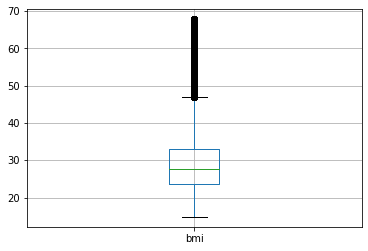

In [0]:
data.boxplot(column='bmi')

los outliers socorro

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8c22cd518>]],
      dtype=object)

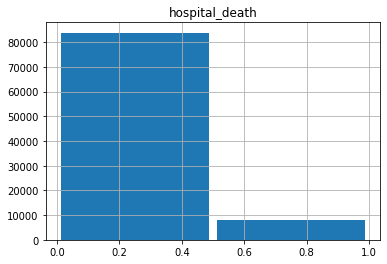

In [0]:
data.hist(column='hospital_death', bins=2, rwidth=0.95)

#### More correlated with target variables

In [0]:
cor = data.corr()

In [0]:
cor_target = abs(cor["hospital_death"])

In [0]:
relevant_features = cor_target[cor_target>0.2]
relevant_features = relevant_features.sort_values(ascending=False)[0:11]
relevant_features

hospital_death                   1.000000
d1_lactate_min                   0.403614
d1_lactate_max                   0.399029
h1_lactate_min                   0.344046
h1_lactate_max                   0.340951
apache_4a_hospital_death_prob    0.311043
apache_4a_icu_death_prob         0.283913
gcs_motor_apache                 0.282449
gcs_eyes_apache                  0.260373
gcs_verbal_apache                0.241044
d1_sysbp_invasive_min            0.234382
Name: hospital_death, dtype: float64

In [0]:
relevant_feat_names =['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','gcs_motor_apache','gcs_eyes_apache','gcs_verbal_apache']

In [0]:
relevant_feat= data[relevant_feat_names]

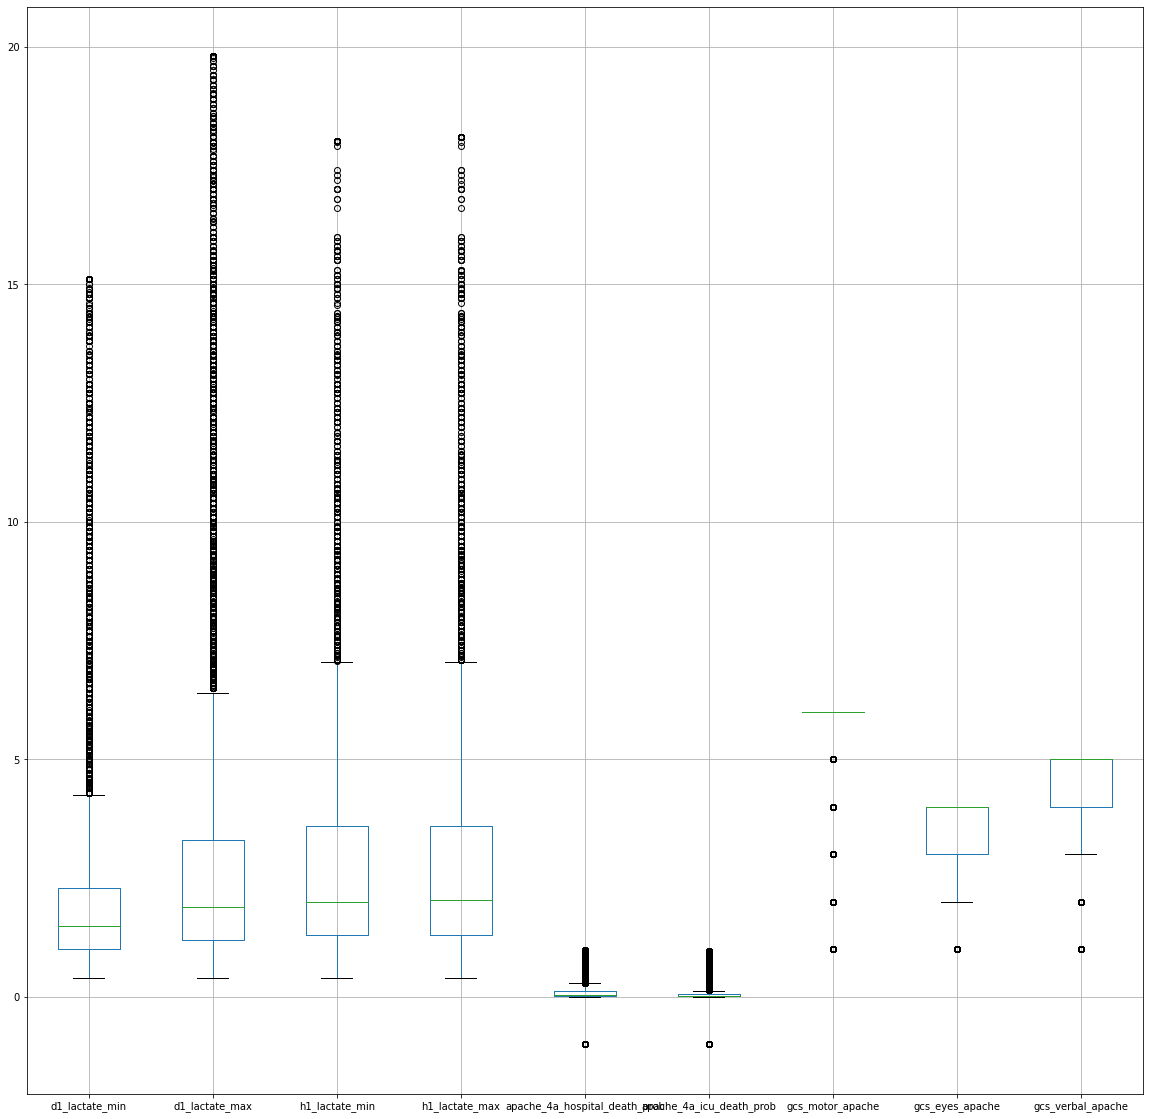

In [0]:
relevant_feat.boxplot(figsize=(20,20))

In [0]:
#valores negativos 
#colas largas

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. U

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8c210cac8>,
      dtype=object)

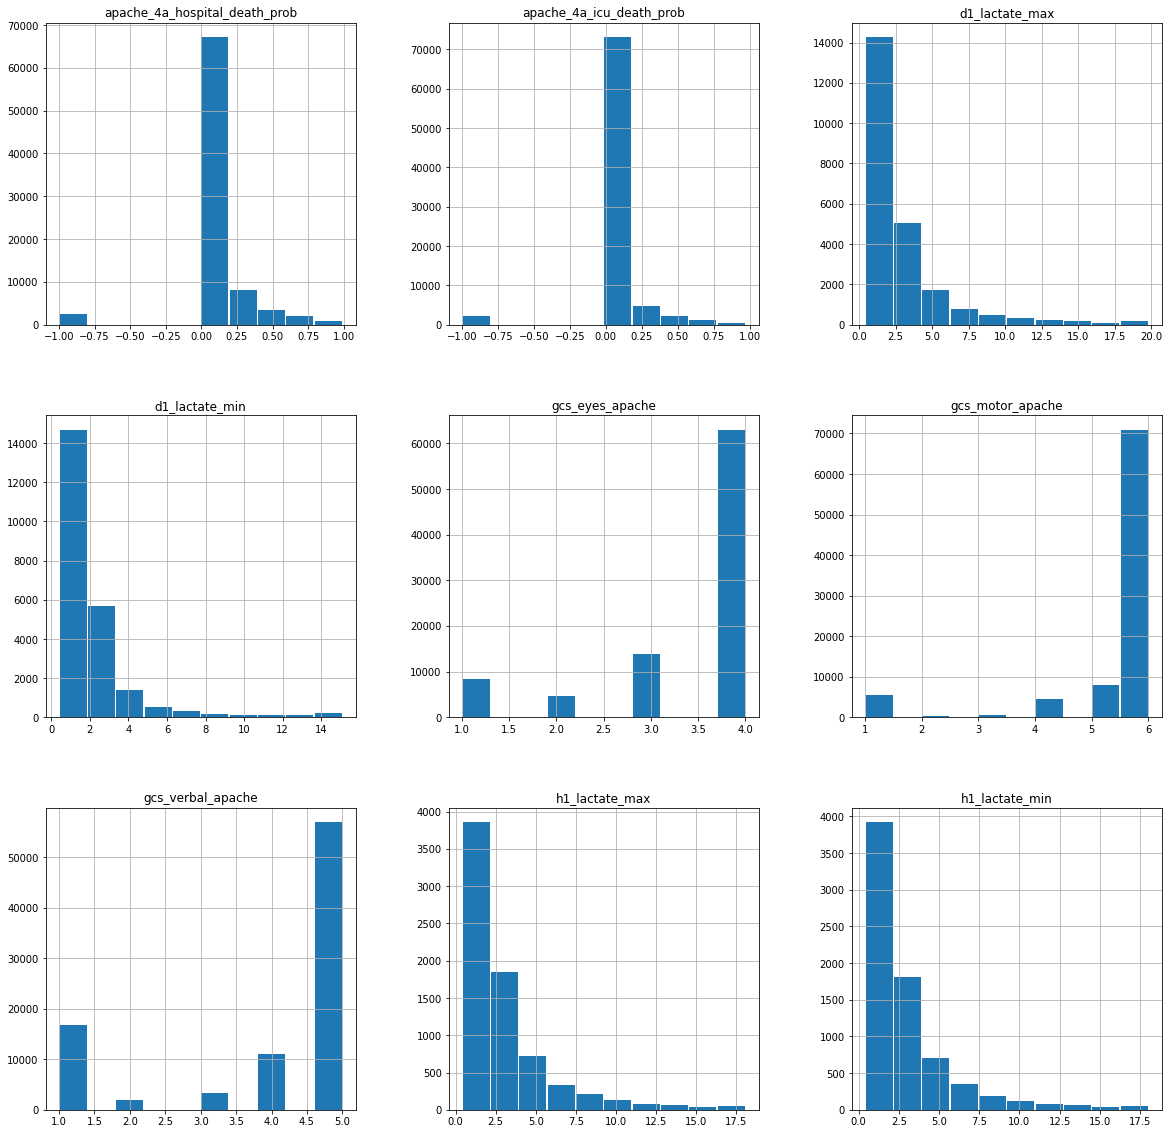

In [0]:
relevant_feat.hist(rwidth=0.95,figsize=(20,20))

#### Categorical data

In [0]:
#categorical_cols =  ['hospital_id', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem',"hospital_death","d1_heartrate_min" ,"d1_resprate_min"]

categorical_cols = data.select_dtypes(exclude=['float']).columns
categorical_cols

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death',
       'elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source',
       'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'readmission_status', 'apache_post_operative', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

In [0]:
data['d1_resprate_min'].dtype

dtype('float64')

In [0]:
Categorical_df= data[categorical_cols]
Categorical_df.head()

encounter_id  patient_id  ...  apache_3j_bodysystem  apache_2_bodysystem
0         66154       25312  ...                Sepsis       Cardiovascular
1        114252       59342  ...           Respiratory          Respiratory
2        119783       50777  ...             Metabolic            Metabolic
3         79267       46918  ...        Cardiovascular       Cardiovascular
4         92056       34377  ...                Trauma               Trauma

[5 rows x 16 columns]

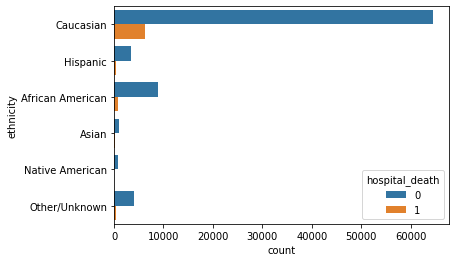

In [0]:
sns.countplot(y="ethnicity", hue="hospital_death" , data=Categorical_df);

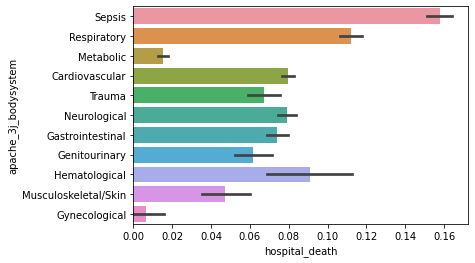

In [0]:
sns.barplot(y="apache_3j_bodysystem", x="hospital_death" , data=Categorical_df);

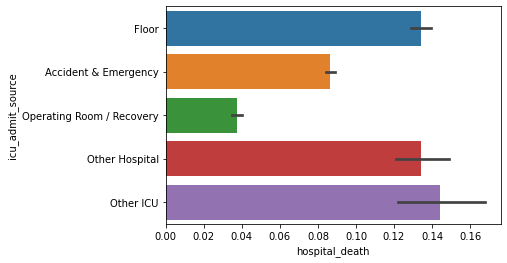

In [0]:
sns.barplot(x="hospital_death", y="icu_admit_source" , data=Categorical_df);

In [0]:
#labels
lab = df["hospital_admit_source"].value_counts().keys().tolist()
#values
val = df["hospital_admit_source"].value_counts().values.tolist()
trace = go.Pie(labels=lab, 
                values=val, 
                marker=dict(colors=['Pink']), 
                # Seting values to 
                hoverinfo="value")
data_var = [trace]
layout = go.Layout(title="Hospital Admit Source")
fig = go.Figure(data = data_var,layout = layout)
iplot(fig)

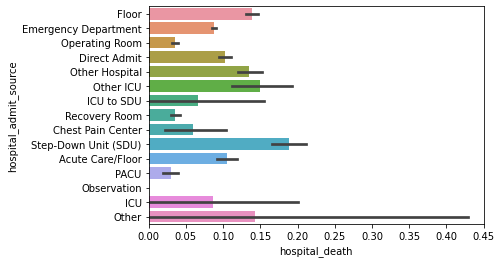

In [0]:
sns.barplot(y="hospital_admit_source", x="hospital_death" , data=data);

#### Missing values

Hay un porron

In [0]:
data.isna().sum().sum()

5743492

In [0]:
data['hospital_death']

0        0
1        0
2        0
3        0
4        0
        ..
91708    0
91709    0
91710    0
91711    0
91712    0
Name: hospital_death, Length: 91713, dtype: int64

In [0]:
data=data.drop(['hospital_death'], axis=1)

1.  Drop the variable if it has more than 50% missing values

In [0]:
threshold = len(data) * 0.60
df_thresh=data.dropna(axis=1, thresh=threshold)
df_thresh.shape

(91713, 111)

In [0]:
df_thresh.isna().sum().sum()

589721

In [0]:
pre_data=df_thresh
pre_data.shape,data.shape

((91713, 111), (91713, 185))

In [0]:
# Documentar las decisiones 
#grafica con porcentaje los valores nulos

2. Categorical variables

In [0]:
categorical_cols = data.select_dtypes(exclude=['float']).columns
Categorical_df= pre_data[np.array(categorical_cols)]

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Categorical_df = imp.fit_transform(Categorical_df)

In [0]:
Categorical_df = pd.DataFrame(Categorical_df)
Categorical_df.columns = np.array(categorical_cols)
Categorical_df.isna().sum().sum()

0

3. Numerical variables

In [0]:
numerical_cols = pre_data.select_dtypes(include=['float']).columns
numerical_cols

Numerical_df= pre_data[numerical_cols]

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
Numerical_df = imp.fit_transform(Numerical_df)

In [0]:
Numerical_df = pd.DataFrame(Numerical_df)
Numerical_df.columns = np.array(numerical_cols)
Numerical_df.isna().sum().sum()

0

In [0]:
Numerical_df.shape,Categorical_df.shape,pre_data.shape

((91713, 96), (91713, 15), (91713, 111))

Uno los dataframe de los numerical data y categorical data sin Nan

In [0]:
pre_data=pd.concat([Numerical_df, Categorical_df],axis=1)

In [0]:
pre_data.isna().sum().sum()

0

#### Unique variables
No aportan valor estadistico

In [0]:
print(pre_data.shape)
display(pre_data.nunique())

(91713, 111)


age                         74
bmi                      34888
height                     401
pre_icu_los_days          9757
weight                    3409
                         ...  
icu_type                     8
readmission_status           1
apache_post_operative        2
apache_3j_bodysystem        11
apache_2_bodysystem         10
Length: 111, dtype: int64

In [0]:
for c in pre_data.columns:
    if pre_data.shape[0]==pre_data[c].nunique():
        print(c)

encounter_id
patient_id


In [0]:
pre_data.drop(['encounter_id', 'patient_id'], axis='columns', inplace=True)

In [0]:
pre_data.shape, data.shape

((91713, 109), (91713, 185))

In [0]:
pre_data.head()

age        bmi  ...  apache_3j_bodysystem  apache_2_bodysystem
0  68.0  22.730000  ...                Sepsis       Cardiovascular
1  77.0  27.420000  ...           Respiratory          Respiratory
2  25.0  31.950000  ...             Metabolic            Metabolic
3  81.0  22.640000  ...        Cardiovascular       Cardiovascular
4  19.0  27.654655  ...                Trauma               Trauma

[5 rows x 109 columns]

#### Ver variables 

In [0]:
pre_data.columns[:36]

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache',
       'ventilated_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min'],
      dtype='object')

In [0]:
pre_data.columns[36:73]

Index(['d1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min', 'd1_bun_max', 'd1_bun_min',
       'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max',
       'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max'],
      dtype='object')

In [0]:
pre_data.columns[73:111]

Index(['d1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'hospital_id', 'elective_surgery',
       'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')

In [0]:
36+36+37

109

In [0]:
pre_data.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache',
       ...
       'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_id',
       'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object', length=109)

Hay muchos en todas las variables 

#### Hot Encoding

In [0]:
'''
clean_data.columns
len(clean_data.columns)
'''

pre_data.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache',
       ...
       'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_id',
       'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object', length=109)

In [0]:
"""variables = []
for i in range(110):
  variables.append(clean_data.columns[i][0])
print(variables)"""

'variables = []\nfor i in range(110):\n  variables.append(clean_data.columns[i][0])\nprint(variables)'

In [0]:
'''clean_data.columns'''

'clean_data.columns'

In [0]:
'''clean_data.head()'''
pre_data.head()

age        bmi  ...  apache_3j_bodysystem  apache_2_bodysystem
0  68.0  22.730000  ...                Sepsis       Cardiovascular
1  77.0  27.420000  ...           Respiratory          Respiratory
2  25.0  31.950000  ...             Metabolic            Metabolic
3  81.0  22.640000  ...        Cardiovascular       Cardiovascular
4  19.0  27.654655  ...                Trauma               Trauma

[5 rows x 109 columns]

In [0]:
categorical_cols = data.select_dtypes(exclude=['float']).columns

In [0]:
categorical_cols

Index(['encounter_id', 'patient_id', 'hospital_id', 'elective_surgery',
       'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')

In [0]:
categoricas = []
for i in categorical_cols:
  categoricas.append(i)
categoricas.remove('encounter_id')
categoricas.remove('patient_id')

categoricas

['hospital_id',
 'elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'readmission_status',
 'apache_post_operative',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [0]:
one_hot_enconding = []
'''for i in categoricas:
  one_hot_enconding.append(pd.get_dummies(clean_data[i], prefix = i))'''
for i in categoricas:
  one_hot_enconding.append(pd.get_dummies(pre_data[i], prefix = i))

In [0]:
#Meter todas las variables a mano que haya que hacer One Hot Encoding

In [0]:
for i in one_hot_enconding:
  clean_data = pd.concat([pre_data, i], axis=1)

In [0]:
list(clean_data)

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'arf_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_ma

In [0]:
for i in categoricas:
  del clean_data[i] #Borramos las variables sueltas

In [0]:
clean_data

age  ...  apache_2_bodysystem_Undefined diagnoses
0      68.0  ...                                        0
1      77.0  ...                                        0
2      25.0  ...                                        0
3      81.0  ...                                        0
4      19.0  ...                                        0
...     ...  ...                                      ...
91708  75.0  ...                                        0
91709  56.0  ...                                        0
91710  48.0  ...                                        0
91711  65.0  ...                                        0
91712  82.0  ...                                        0

[91713 rows x 106 columns]

In [0]:
for i in clean_data.columns:
    if 'hospital' in i:
        print (i)

apache_4a_hospital_death_prob


In [0]:
#### Atribute Selection 

#### Fearure importance

In [0]:
X=clean_data
len(X.columns)

106

In [0]:
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

age  ...  apache_2_bodysystem_Undefined diagnoses
age               1.000000  ...                                 0.027576
bmi               0.086472  ...                                 0.031674
height            0.108982  ...                                 0.041920
pre_icu_los_days  0.048416  ...                                 0.084902
weight            0.126515  ...                                 0.048739

[5 rows x 106 columns]

In [0]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
X = X.drop(columns = to_drop)

There are 22 columns to remove.


In [0]:
# Train missing values (in percent)
train_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
train_missing.head()
train_missing = train_missing.index[train_missing > 0.75]
print('There are %d columns with more than 75%% missing values' % len(train_missing))
X = X.drop(columns = train_missing)

There are 0 columns with more than 75% missing values


In [0]:
len(X.columns)

84

In [0]:
#X = pd.get_dummies(X)

In [0]:
len(X.columns)

84

In [0]:
feature_importances = np.zeros(X.shape[1])


In [0]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [0]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.891401	valid_0's binary_logloss: 0.317987
Early stopping, best iteration is:
[107]	valid_0's auc: 0.893241	valid_0's binary_logloss: 0.353321
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.887243	valid_0's binary_logloss: 0.323175
Early stopping, best iteration is:
[123]	valid_0's auc: 0.889293	valid_0's binary_logloss: 0.349218


In [0]:
len(X.columns),len(train_features.columns),len(valid_features.columns),len(feature_importances)

(84, 84, 84, 84)

In [0]:
#feature_importances

In [0]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

feature  importance
64  apache_4a_hospital_death_prob       141.5
27               d1_heartrate_min       115.5
0                             age       112.0
6             apache_3j_diagnosis       101.5
9               creatinine_apache        95.5

In [0]:
len(feature_importances)

84

In [0]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()
# Drop features with zero importance
X = X.drop(columns = zero_features)

There are 4 features with 0.0 importance


In [0]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
     # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    return df

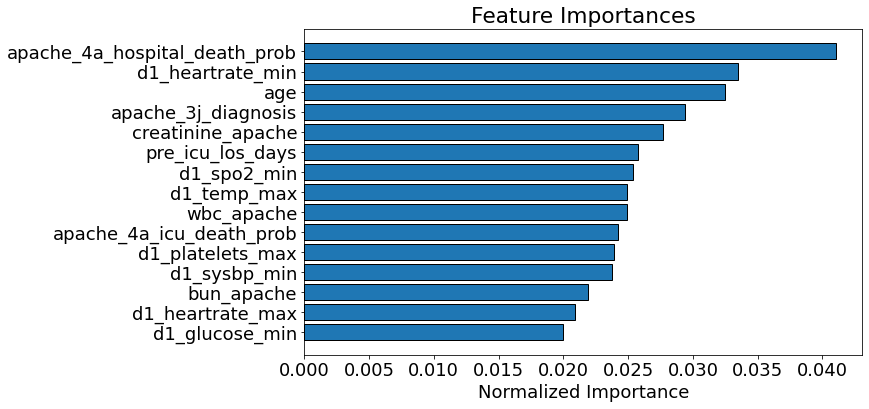

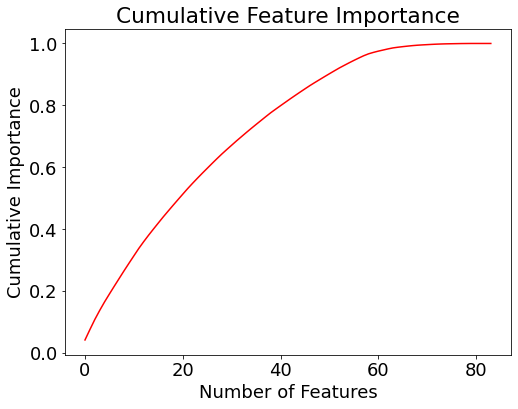

51 features required for 0.90 of cumulative importance


In [0]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [0]:
feature_importances[:52]

feature  importance
64  apache_4a_hospital_death_prob       141.5
27               d1_heartrate_min       115.5
0                             age       112.0
6             apache_3j_diagnosis       101.5
9               creatinine_apache        95.5
3                pre_icu_los_days        89.0
33                    d1_spo2_min        87.5
36                    d1_temp_max        86.0
23                     wbc_apache        86.0
65       apache_4a_icu_death_prob        83.5
59               d1_platelets_max        82.5
35                   d1_sysbp_min        82.0
8                      bun_apache        75.5
26               d1_heartrate_max        72.0
54                 d1_glucose_min        69.0
37                    d1_temp_min        68.0
29                     d1_mbp_min        67.5
1                             bmi        64.5
31                d1_resprate_min        64.0
30                d1_resprate_max        63.0
14                 glucose_apache        62.5
4                          weight        62.0
19                resprate_apache        59.0
34                   d1_sysbp_max        57.0
62                  d1_sodium_max        56.0
18                     map_apache        54.5
16              hematocrit_apache        54.5
58              d1_hemaglobin_min        53.5
15              heart_rate_apache        52.0
55                    d1_hco3_max        49.5
40               h1_heartrate_max        48.5
57              d1_hemaglobin_max        48.5
2                          height        46.5
61               d1_potassium_min        46.5
28                     d1_mbp_max        45.5
5              apache_2_diagnosis        44.5
45                h1_resprate_min        44.0
41               h1_heartrate_min        44.0
49                   h1_sysbp_min        43.0
24                  d1_diasbp_max        39.5
53                 d1_calcium_min        39.0
25                  d1_diasbp_min        38.5
56                    d1_hco3_min        38.5
38                  h1_diasbp_max        37.5
43                     h1_mbp_min        37.0
48                   h1_sysbp_max        36.5
21                    temp_apache        36.0
63                  d1_sodium_min        34.0
39                  h1_diasbp_min        33.0
22              ventilated_apache        33.0
11               gcs_motor_apache        32.5
52                 d1_calcium_max        32.0

In [0]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, y, test_size=0.2, random_state=1)

# Mayoría de votos

In [0]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=100)
# Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=1)
# Voting Classifier with soft voting 
votingC = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
votingC = votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

In [0]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9286921441421796
[[16561   185]
 [ 1123   474]]


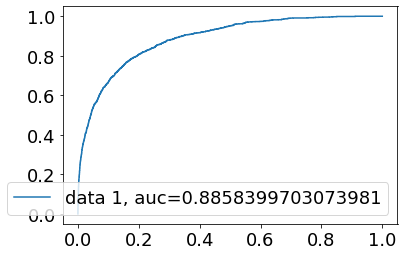

In [0]:
y_pred_proba = votingC.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Boosted Trees

In [0]:
clf = GBC.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9282560104672082
[[16525   221]
 [ 1095   502]]


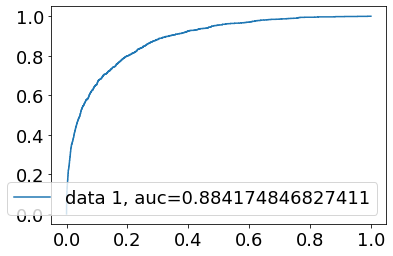

In [0]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Random Forest

In [0]:
clf = RFC.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9278743935016083
[[16582   164]
 [ 1159   438]]


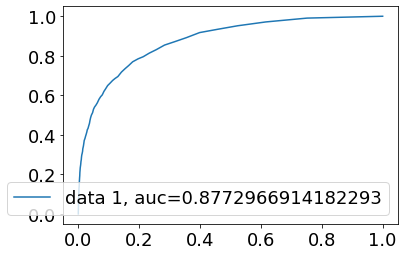

In [0]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Correlation Map

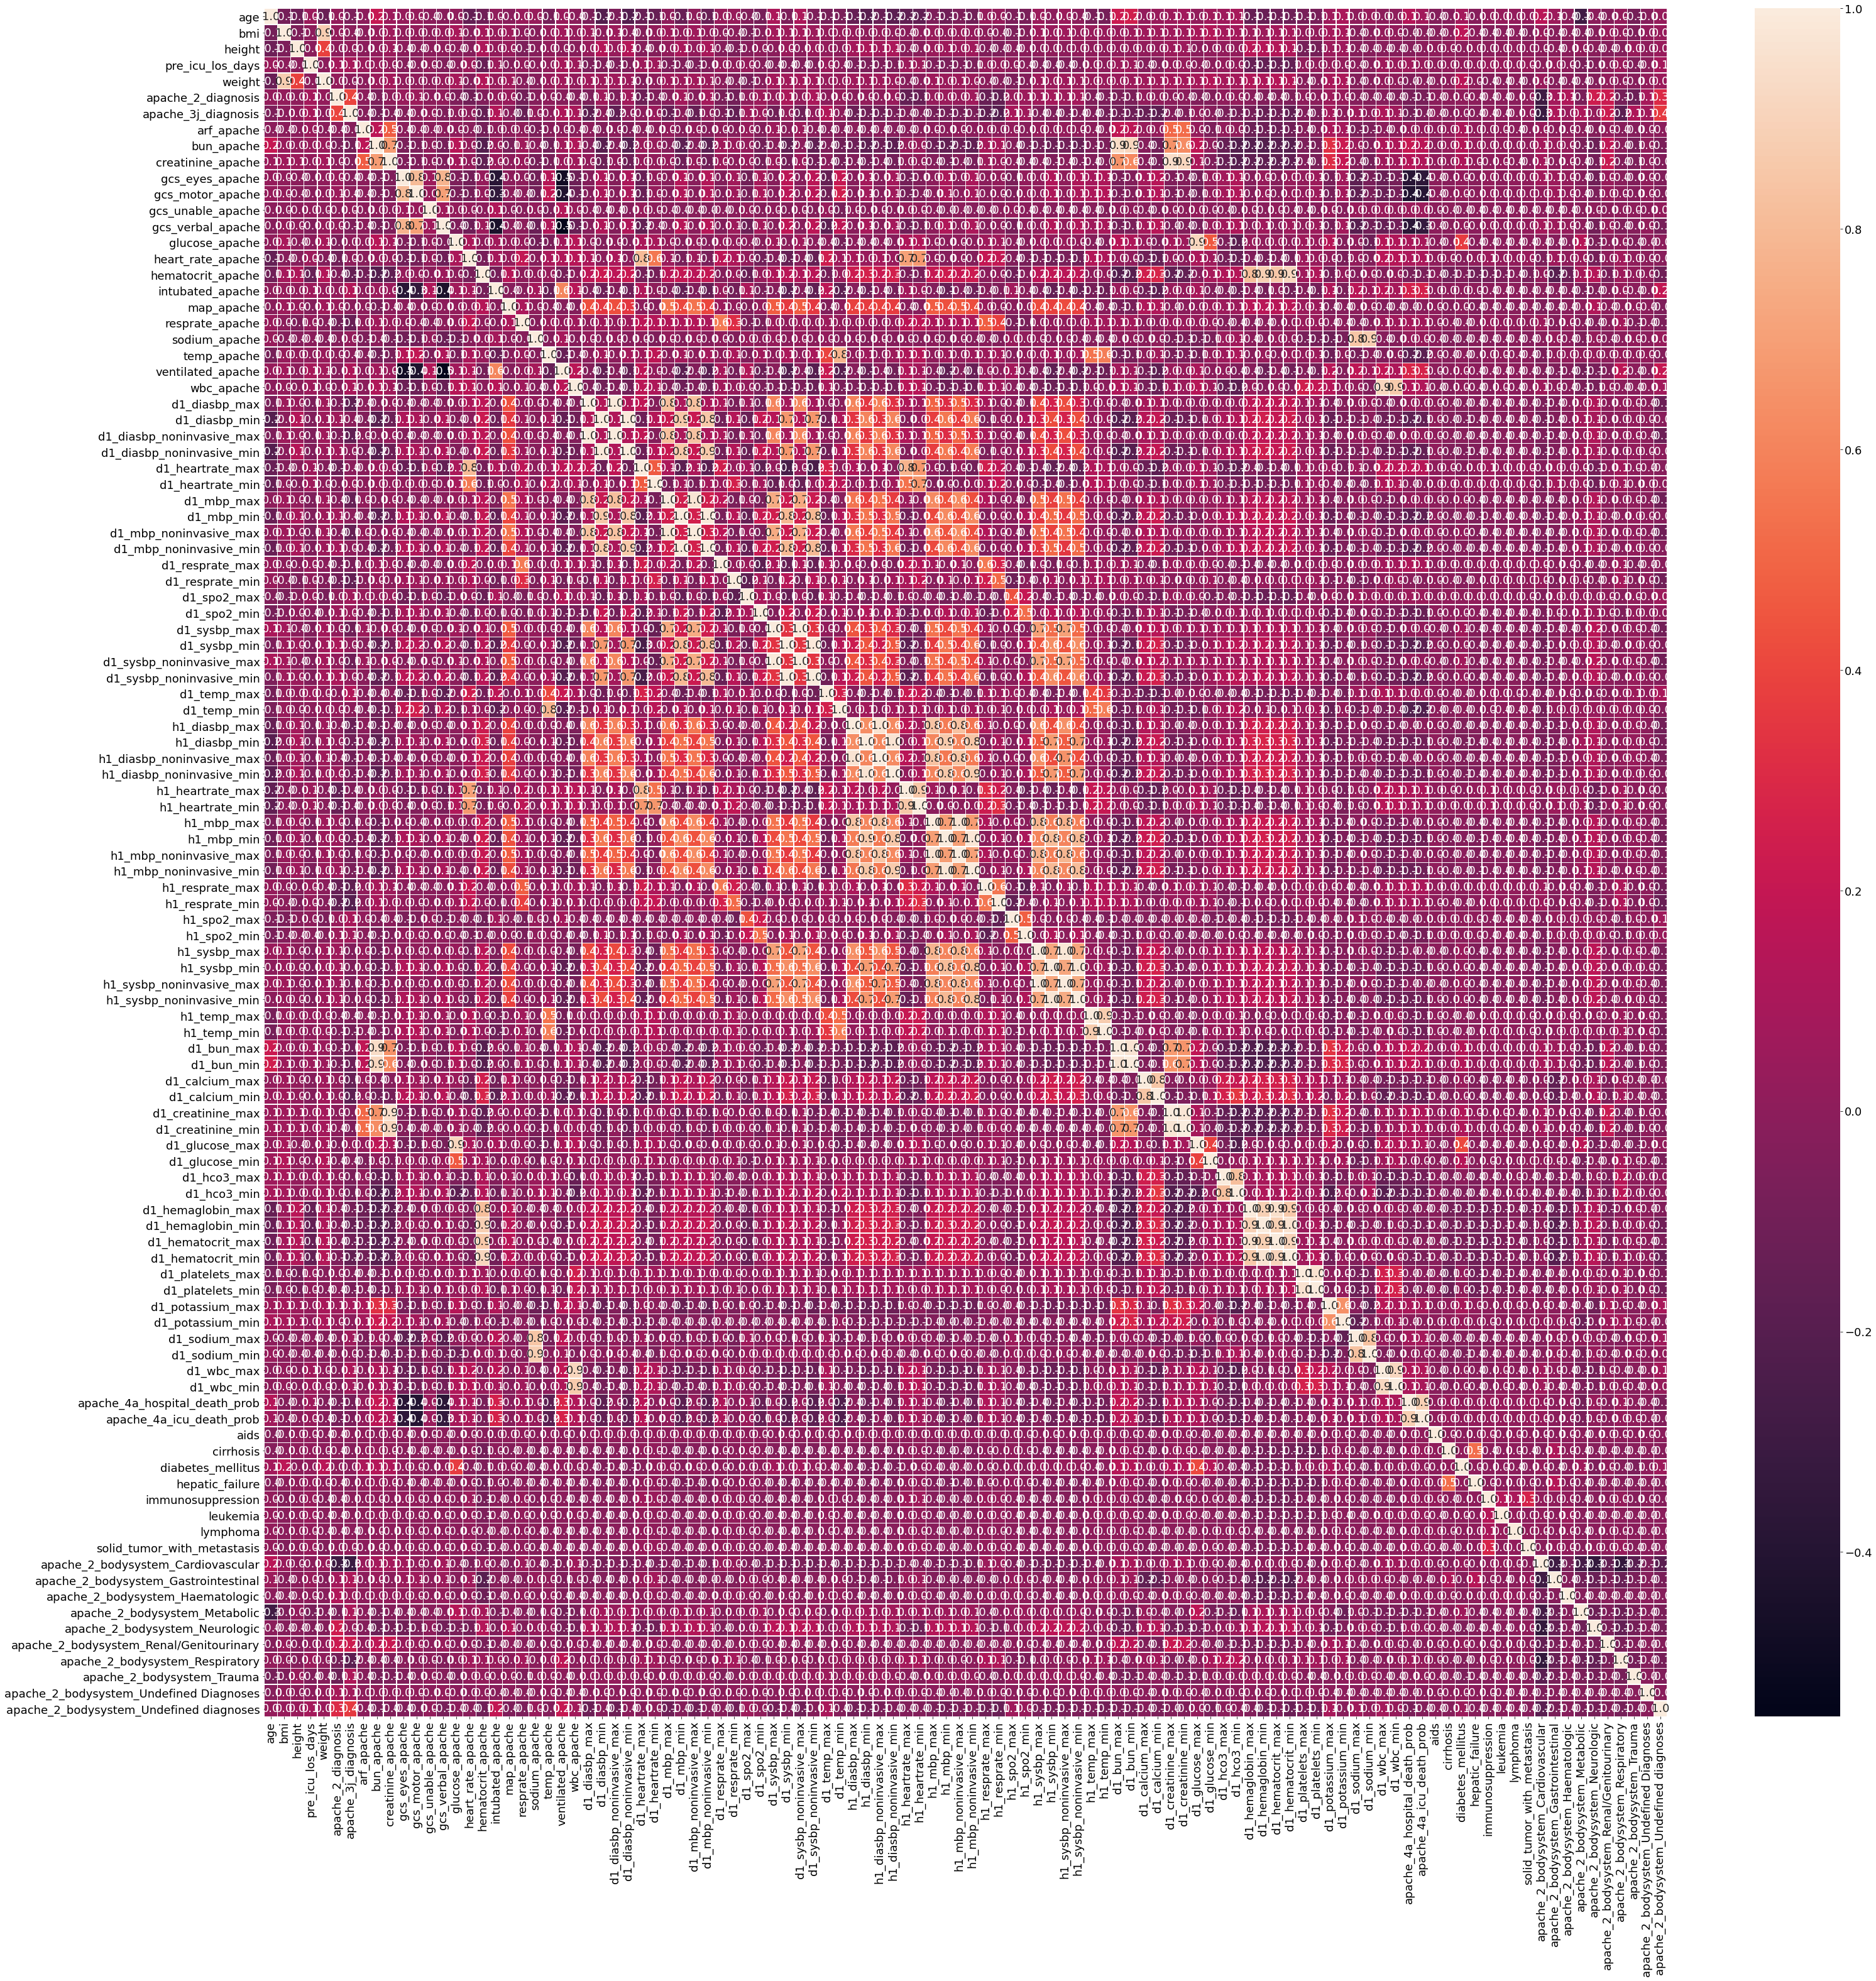

In [0]:
#correlation map
f,ax = plt.subplots(figsize=(50, 50))
sns.heatmap(clean_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [0]:
def matriz_confusion(cnf):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')